<a href="https://colab.research.google.com/github/neworderofjamie/riscv_ise/blob/compiler/tutorials/alif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are lots of rough edges here: error checking is lacking in places, the compiler supports an even smaller subset of C than it should and the wrapping of various bits of API is not very Pythonic.

# Installation
The current prototype FeNN toolchain is a little bit tricky to build as it re-uses parts of GeNN (mostly the type system and the GeNNCode scanner, parser and type checker) so, on colab, we can install a prebuilt wheel from my google drive:

In [1]:
if "google.colab" in str(get_ipython()):
    !gdown 1hEx5nI2ITfmrrjfidr5y1SyWnsjFI8Qq
    !pip install pyfenn-0.0.1-cp311-cp311-linux_x86_64.whl

Downloading...
From: https://drive.google.com/uc?id=1hEx5nI2ITfmrrjfidr5y1SyWnsjFI8Qq
To: /content/pyfenn-0.0.1-cp311-cp311-linux_x86_64.whl
100% 6.38M/6.38M [00:00<00:00, 55.5MB/s]
Processing ./pyfenn-0.0.1-cp311-cp311-linux_x86_64.whl


In [13]:
import numpy as np
import matplotlib.pyplot as plt

from pyfenn import (BackendFeNNSim, CopyProcess, EventContainer, Model, NeuronUpdateProcess,
                    NumericValue, Parameter, PlogSeverity, ProcessGroup,
                    Runtime, Shape, UnresolvedType, Variable)

from pyfenn import disassemble, init_logging
from pyfenn.utils import get_array_view, zero_and_push

In [4]:
background_rate = 0.5
rate = 7846 / 1370
num_timesteps = 1000



In [5]:
# Generate poisson data with two periods of average firing interspersed by background
data = np.zeros(num_timesteps)
data[0:1000] = np.random.poisson(rate, 1000)
"""
data[0:2000] = np.random.poisson(rate, 2000)
data[2000:4000] = np.random.poisson(background_rate, 2000)
data[4000:5000] = np.random.poisson(rate, 1000)

data_bad = np.zeros(num_timesteps)
data_bad[0:2000] = np.random.poisson(rate, 2000)
data_bad[2000:4000] = np.random.poisson(rate * 1.4, 2000)
data_bad[4000:5000] = np.random.poisson(rate * 1.7, 1000)
"""
repeated_data = np.repeat(data[:,None], 32, axis=1).astype(np.int16)
#repeated_data_bad = np.repeat(data_bad[:,None], 32, axis=1).astype(np.int16)

Text(0.5, 0, 'Time [timestep]')

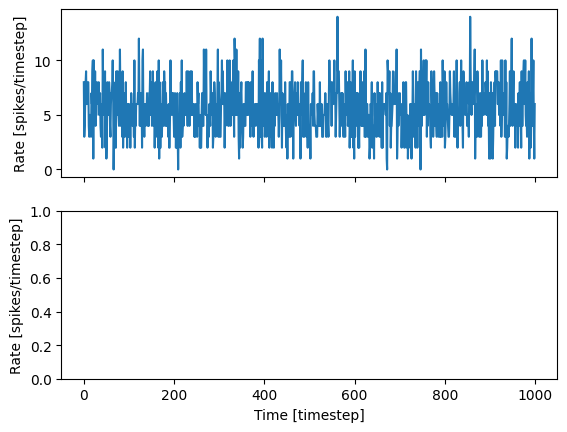

In [8]:
fig, axes = plt.subplots(2, sharex=True)

axes[0].plot(data)
#axes[1].plot(data_bad)

axes[0].set_ylabel("Rate [spikes/timestep]")
axes[1].set_ylabel("Rate [spikes/timestep]")
axes[1].set_xlabel("Time [timestep]")

In [14]:
class Copy:
    def __init__(self, source: Variable, num_timesteps: int = 1):
        self.target = Variable(source.shape,
                               UnresolvedType(source.type),
                               num_timesteps,
                               f"{source.name}_copy")
        self.process = CopyProcess(source, self.target)

In [10]:
class ALIF:
    def __init__(self, shape, tau_m: float, tau_a: float, tau_refrac: int,
                 v_thresh: float, beta: float, weight:float, num_timesteps: int):
        self.shape = Shape(shape)
        v_dtype = UnresolvedType("s6_9_sat_t")
        a_dtype = UnresolvedType("s6_9_sat_t")
        decay_dtype = UnresolvedType("s0_15_sat_t")
        self.v = Variable(self.shape, v_dtype)
        self.a = Variable(self.shape, a_dtype)
        self.i = Variable(self.shape, v_dtype, num_timesteps)
        self.refrac_time = Variable(self.shape, UnresolvedType("int16_t"))
        self.process = NeuronUpdateProcess(
            """
            V = (Alpha * V) + (Weight * I);
            A *= Rho;

            if (RefracTime > 0) {
               RefracTime -= 1;
            }
            else if(V >= (VThresh + (Beta * A))) {
               V -= VThresh;
               A += 1.0h9;
               RefracTime = TauRefrac;
            }
            """,
            {"Alpha": Parameter(NumericValue(np.exp(-1.0 / tau_m)), decay_dtype),
             "Rho": Parameter(NumericValue(np.exp(-1.0 / tau_a)), decay_dtype),
             "VThresh": Parameter(NumericValue(v_thresh), v_dtype),
             "Beta": Parameter(NumericValue(beta), v_dtype),
             "Weight": Parameter(NumericValue(weight), v_dtype),
             "TauRefrac": Parameter(NumericValue(tau_refrac), UnresolvedType("int16_t"))},
            {"V": self.v, "A": self.a, "I": self.i, "RefracTime": self.refrac_time})


In [15]:

init_logging(PlogSeverity.DEBUG)

# Model
neurons = ALIF([32], 20.0, 2000, 5, 0.6, 0.0174, 0.01, num_timesteps)
copy_v = Copy(neurons.v, num_timesteps)
copy_a = Copy(neurons.a, num_timesteps)

# Group processes
neuron_update_processes = ProcessGroup([neurons.process])
copy_process = ProcessGroup([copy_v.process, copy_a.process])

# Create model
model = Model([neuron_update_processes, copy_process])

# Create backend and use to generate sim code
backend = BackendFeNNSim()
code = backend.generate_simulation_kernel([neuron_update_processes, copy_process],
                                          [],
                                          num_timesteps, model)

# Disassemble if required
if True:
    for i, c in enumerate(code):
        print(f"{i * 4} : {disassemble(c)}")

# Create runtime
runtime = Runtime(model, backend)

# Allocate memory for model
runtime.allocate()

# Zero remaining state
zero_and_push(neurons.v, runtime)
zero_and_push(neurons.a, runtime)
zero_and_push(neurons.refrac_time, runtime)

# Copy input currents to device
input_i_array, input_i_view = get_array_view(runtime, neurons.i, np.int16)
input_i_view[:] = repeated_data.flatten()
input_i_array.push_to_device()

# Set instructions
runtime.set_instructions(code)

# Simulate
runtime.run()


0 : ADDI X1, X0, 0
4 : ADDI X2, X0, 1000
8 : VLUI V2, 512
12 : VLUI V1, 1
16 : VLUI V0, 0
20 : ADDI X3, X0, 64
24 : LW X4, 0(X0)
28 : LW X5, 4(X0)
32 : MUL X6, X1, X3
36 : ADD X5, X5, X6
40 : LW X6, 8(X0)
44 : LW X7, 12(X0)
48 : VLUI V3, 5
52 : VLUI V4, 5
56 : VLUI V5, 9
60 : VLUI V6, 32752
64 : VLUI V7, 307
68 : VLUI V8, 31170
72 : VLOAD V9, 0(X4)
76 : VLOAD V10, 0(X5)
80 : VLOAD V11, 0(X6)
84 : VLOAD V12, 0(X7)
88 : VMUL V13, V8, V12, 15
92 : VMUL V14, V4, V10, 9
96 : VADD_S V15, V13, V14
100 : VADD V12, V15, V0
104 : VMUL V11, V11, V6, 15
108 : VTLT X3, V0, V9
112 : VSUB V13, V9, V1
116 : VSEL V9, X3, V13
120 : XORI X8, X3, -1
124 : VMUL V13, V5, V11, 9
128 : VADD_S V14, V7, V13
132 : VTGE X9, V12, V14
136 : AND X10, X8, X9
140 : VSUB_S V13, V12, V7
144 : VSEL V12, X10, V13
148 : VADD_S V13, V11, V2
152 : VSEL V11, X10, V13
156 : VSEL V9, X10, V3
160 : VSTORE V9, 0(X4)
164 : VSTORE V10, 0(X5)
168 : VSTORE V11, 0(X6)
172 : VSTORE V12, 0(X7)
176 : LW X4, 16(X0)
180 : LW X3, 20(X0)
184

In [ ]:

neurons_v_copy_array, neurons_v_copy_view = get_array_view(runtime, copy_v.target,
                                                           np.int16)
neurons_a_copy_array, neurons_a_copy_view = get_array_view(runtime, copy_a.target,
                                                           np.int16)

neurons_v_copy_array.pull_from_device()
neurons_a_copy_array.pull_from_device()

# **YUCK** reshape
neurons_v_copy_view = np.reshape(neurons_v_copy_view, (-1, 32))
neurons_a_copy_view = np.reshape(neurons_a_copy_view, (-1, 32))

# Calculate mean and standard deviation
neurons_v_mean = np.average(neurons_v_copy_view, axis=1)
neurons_v_std = np.std(neurons_v_copy_view, axis=1)
neurons_a_mean = np.average(neurons_a_copy_view, axis=1)
neurons_a_std = np.std(neurons_a_copy_view, axis=1)

fig, axis = plt.subplots()

a_axis = axis.twinx()

axis.plot(neurons_v_mean)
a_axis.plot(neurons_a_mean)
plt.show()